## Introduction

---
This notebook will provide a quick introduction into the mechanics of using CivisML. It's the notebook I wish I had had when I started using CivisML, and it provides a way to start gaining meaning from your data quickly. 

CivisML is a machine learning service accessible in Civis Platform. It’s built around scikit-learn, the popular open-source machine learning library for Python. Scikit-learn has a well-defined API, which lets CivisML handle any model that you can define with the library. With CivisML, you can hand a scikit-learn model to Civis Platform and the platform will fit the model, store the results, and plot model diagnostics such as the ROC curve. (You can read how to use it in our [documentation](http://civis-python.readthedocs.io/en/latest/ml.html).)

CivisML uses the Civis Platform to train machine learning models and parallelize their predictions over large datasets. It contains best-practice models for general-purpose classification and regression modeling as well as model quality evaluations and visualizations. All CivisML models use scikit-learn for interoperability with other platforms and to allow you to leverage resources in the open-source software community when creating machine learning models. CivisML automates many of the repetitive tasks a Data Scientist performs in scikit-learn, making it possible to try many more modeling ideas with many fewer lines of code. 

In this notebook, I will explore some of my major use cases (e.g. trying different algorithms, firing off many models in unison with different hyperparameters, and analyzing cross-validated results). The classifiers I build below are all from publicly available data at the UCI Machine Learning Repository[1][2]. Learn more about the [dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/).

**CivisML uses the Civis API.  If you'd like to run this code yourself, consider signing up for a [free trial](https://www.civisanalytics.com/civis-platform-signup/).**

---
The Wisconsin Breast Cancer (Diagnostic) Data Set records anonymous data on ~600 patients' cells, along with whether those cells are cancerous or benign. We can create a classifier to predict which cells are dangerous!

---
[1]: O. L. Mangasarian and W. H. Wolberg: "Cancer diagnosis via linear programming", SIAM News, Volume 23, Number 5, September 1990, pp 1 & 18.

[2]: Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

#### TL;DR: Why Would I Use This?
- CivisML easily parallelizes your modeling tasks, making it fast to try lots of ideas
- Diagnostic and other results are accessible in fewer lines of code
- The package works with any scikit-learn estimators, so if you have your own pipeline already you can still get the benefits of CivisML

In [2]:
# packages for downloading the data
import os
import urllib

# packages for munging, plotting, machine learning
import pandas as pd
import numpy as np
import xgboost
import matplotlib.pyplot as plt
%matplotlib inline

# package to help with parallelization
from concurrent import futures

# packages for CivisML
import civis
from civis.ml import ModelPipeline

In [3]:
print("Pandas version: {}".format(pd.__version__))
print("Civis version: {}".format(civis.__version__))
print("Xgboost version: {}".format(xgboost.__version__))

Pandas version: 0.19.2
Civis version: 1.5.2
Xgboost version: 0.6


## Downloading Data
- First things first, we need to grab the data from UCI ML Repository

In [4]:
%%time
DATA_URL = "http://mlr.cs.umass.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"

if not os.path.isfile('breast_cancer_data.csv'):
    print("Fetching data...")
    opener = urllib.request.URLopener()
    opener.retrieve(DATA_URL, "breast_cancer_data.csv")
    print("File Size: {:.1f} KB".format(os.path.getsize('breast_cancer_data.csv') / (1024*100)))
    print("Finished")
else:
    print("breast_cancer_data.csv already downloaded")

Fetching data...
File Size: 0.2 KB
Finished
CPU times: user 6.06 ms, sys: 4.31 ms, total: 10.4 ms
Wall time: 113 ms


## Munging Data
- We'll add in the column names, and tell pandas that null values are encoded as a '?'.
- We can peek at shape. This is a small table, which I chose to allow for quick training.
- We'll recode the response 4 (cancer) and 2 (benign) as 1 and 0 respectively (keeping care to ensure null values are retained). **I don't have to do this**, but to me it feels more intuitive to deal with ones and zeros

In [5]:
COL_NAMES = ['sample_id', 'clump_thickness', 'uniformity_cell_size', 'uniformity_cell_shape',
            'marginal_adhesion', 'epithelial_cell_size', 'bare_nuclei', 'bland_chromatin',
            'normal_nucleoli', 'mitoses', 'is_cancer']
df = pd.read_csv("breast_cancer_data.csv", names=COL_NAMES, na_values='?')

print("Shape: ", df.shape)

df['is_cancer'] = [1 if val == 4 else (0 if val == 2 else np.nan) for val in df['is_cancer'] ]
# df.head()

Shape:  (699, 11)


## Training Models

#### Using CivisML builtin algorithms

We can start by trying a few different algorithms to fit our classifier. CivisML uses a ModelPipeline object to encapsulate training and predicting. A few important details:

- There are several pre-defined model types you can use to create a pipeline (check the docs above for a full list).
- sparse_logistic will create an L1 penalized logistic regression for variable selection, then build an unpenalized logistic regression from the selected variables
- I need to explicitly pass which column is the dependent variable

I'll initialize the pipelines below

In [6]:
workflows = ['sparse_logistic',
             'random_forest_classifier',
             'extra_trees_classifier']

models = []
for wf in workflows:
    model = ModelPipeline(model=wf,
                          dependent_variable="is_cancer",
                          model_name=wf)
    models.append(model)

#### Trying different hyperparameters

Another thing I'm often doing is building lots of models with tweaked hyperparameters, to see what fits best.

Let's add a bunch of gradient_boosted_classifiers with different params from the defaults.

The code below passes a dict of hyperparameter choices to the ModelPipeline. **CivisML will automatically try all combinations of hyperparameter choices, and report back results from the best one** on the cross-validated data set.

In [7]:
cv_params = {'learning_rate': [0.01, 0.2],
             'n_estimators': [50, 200],
             'max_depth': [1, 2]}
model = ModelPipeline(model='gradient_boosting_classifier',
                      dependent_variable="is_cancer",
                      cross_validation_parameters=cv_params,
                      model_name='best_gbc_from_hyperparam_search')
models.append(model)

#### Creating your own estimator

Last but not least, I might want to roll my own classifier, apart from CivisML builtins. CivisML makes a few scikit-learn compatible estimators available. You can see a list of them [here](https://civis-python.readthedocs.io/en/v1.5.2/ml.html#custom-models). It's easy to take your existing code and still get the benefits of CivisML parallelizability and metrics reporting.

I've been playing around a lot recently with xgboost, let's create and parameterize our own XGBClassifier.

In [8]:
xgb = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.01)
model = ModelPipeline(model=xgb,
                      dependent_variable='is_cancer',
                      model_name='xgb_classifier')
models.append(model)

---
Great! Let's train several models. CivisML makes it really simple to kick off many parallel jobs. Creating a ModelPipeline is much like creating a scikit-learn model, in that it doesn't cause anything to happen computationally until the user calls "train" or "predict."

The futures.wait function will block until all models finish training. This might take a few minutes. Time for a coffee, maybe?

In [9]:
%%time 
future_jobs = [model.train(df=df) for model in models]
futures.wait(future_jobs)

CPU times: user 756 ms, sys: 70.1 ms, total: 826 ms
Wall time: 38.3 s


The output of model.train() is a futures object. Calling .succeeded() on it will allow me to check the status of my job.

Let's make sure that the state of each training job is "succeeded." Jobs might fail, for example, if we drop a connection with the server. If this is the case, we can simply rerun the pipeline.

In [10]:
all_success = all([model_fut.succeeded() for model_fut in future_jobs])
print("All successful: {}".format(all_success))

All successful: True


## Visualizing Results

Let's create ROC curves for our cross-validated training results so that we can get a visual idea of how well our models are performing. CivisML provides validation data in the **metrics** dict of each futures object. Pulling this out and graphing it makes it easy to evaluate our models. These models appear to be doing fantastic!

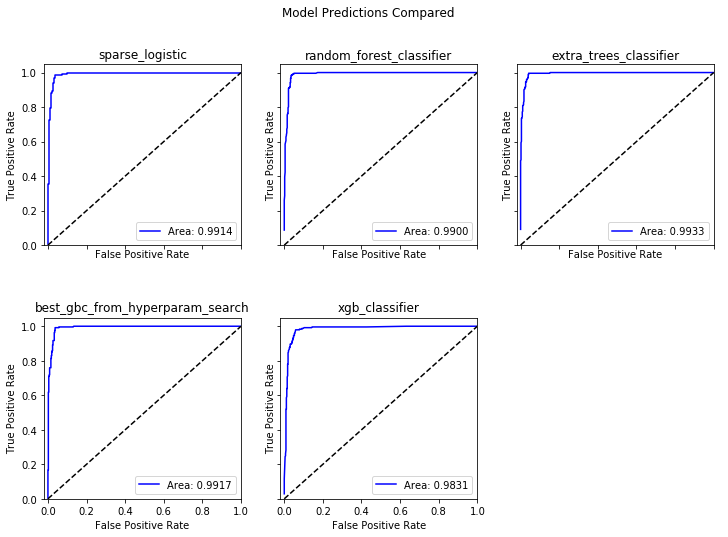

In [11]:
def extract_roc(fut_job):
    metrics = fut_job.metrics
    return metrics['roc_curve']['fpr'], metrics['roc_curve']['tpr'], metrics['roc_auc']


def plot_one_roc_curve(ax, model_name, fpr, tpr, roc_auc):
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")
    ax.set_xlim([-0.02, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_title(model_name)
    ax.plot(fpr, tpr, color='blue', label="Area: {:.4f}".format(roc_auc))
    ax.plot([0,1], [0,1], 'k--')
    ax.legend(loc="lower right")
    
    
rocs = [extract_roc(fut_job) for fut_job in future_jobs]
model_names = [model.model_name for model in models]
fig, axes = plt.subplots(2, 3, sharex="col", sharey="row", figsize=(12,8))
fig.suptitle("Model Predictions Compared")
fig.subplots_adjust(hspace=0.4)

# Last axis object has no data, hide it
axes[-1, -1].axis('off')

axes = axes.ravel()[:5]
assert len(rocs) == len(model_names)
assert len(axes) == len(model_names)
for ax, model_name, roc in zip(axes, model_names, rocs):
    fpr, tpr, roc_auc = roc
    plot_one_roc_curve(ax, model_name, fpr, tpr, roc_auc);
    

## Scoring New, Unlabeled Data
- Another common piece of my workflow is scoring unlabeled data with my model.
- I had a complete data set to start, but I'll simulate a test data set here by sampling my original df.

In [12]:
test_set = df.sample(frac=0.2, random_state=47)
# test_set.head()

Like training jobs, scoring jobs can also be fired off in parallel

In [13]:
%%time
future_scores = [model.predict(df=test_set) for model in models]
futures.wait(future_scores)

CPU times: user 492 ms, sys: 38.3 ms, total: 530 ms
Wall time: 38.9 s


Again, let's make sure that all our scoring jobs completed successfully, and re-run if necessary!

In [14]:
all_success_scoring = all([score_fut.succeeded() for score_fut in future_scores])
print("All successful scoring: {}".format(all_success_scoring))

All successful scoring: True


Pulling out tables of results is as simple as accessing the 'table' attribute of my scoring job. We can check what the probability of cancer is according to our first model and the first 5 rows of the test set below.

In [15]:
score_tables = [score_job.table for score_job in future_scores]
score_tables[0].head()

,is_cancer_1
0,0.074928
1,0.003622
2,0.990506
3,0.999862
4,0.800179


## Model Persistence

CivisML automatically stores your training jobs, which is convenient when you're dealing with larger datasets and training is slower. To grab a previously trained model, **simply find your model's job_id and run_id.** My 3rd job (the extra trees classifier) slightly outperformed the rest, so I'll look at it specifically.

In [16]:
extra_trees_job_id = future_jobs[2].job_id
extra_trees_run_id = future_jobs[2].run_id
print("Job Id: {}".format(extra_trees_job_id))
print("Run Id: {}".format(extra_trees_run_id))

Job Id: 5865784
Run Id: 50123730


- from_existing takes job_id and run_id, and reloads the trained model
- I'll call .result() on my predict job to get it to block until finished

In [17]:
loaded_model = ModelPipeline.from_existing(extra_trees_job_id, extra_trees_run_id)

loaded_fut = loaded_model.predict(df=test_set)
print(loaded_fut.result()['state'])
loaded_fut.table.head()

succeeded


,is_cancer_1
0,0.0
1,0.0
2,1.0
3,1.0
4,1.0
